# Análise de Usuários através de Keystrokes

### Autor: Guilherme Freire

Nesse trabalho, busco explorar o quanto o modo como um usuário digita diz sobre ele. É possível dicerní-lo de outros apenas por seu padrão de digitação? Conseguimos agrupar usuários que digitam de forma parecida? O que mais é possível extrair de dados de telcas?

## Motivação

Qual a utilidade de ser se estudar padrões de digitação de um usuário?

Assumindo que cada usuário tem um padrão de digitação único, ou pelo menos razoavelmente único, é possível pensar em uma tarefa de identificação. Sites como o Coursera utilizam esses dados justamente para julgar se um aluno realmente está fazendo os deveres do curso. Logo quando um usuário se cadastra, ele deve digitar um parágrafo para que um perfil associado seja criado. Esse perfil é, então, comparado posteriormente aos textos (códigos ou respostas discursivas) escritos pelo aluno. Por ser utilizado por tanto tempo na plataforma, podemos suspeitar que esse tipo de dado é um bom indicativo de unicidade.

Outra aplicação possível é identificação de usuários fazendo login. Se um sistema for capaz de identificar o usuário pelo modo como digita, uma camada a mais de segurança pode ser criada. Afinal, não basta saber a senha da conta, é necessário digitar como o dono original digita. Dessa forma, fraudes por senhas vazadas, bancos de dados comprometidos, ou até mesmo senhas anotadas em _post-its_ no monitor podem ser evitadas.

Para o caso de uso da senha é interessante notar um detalhe que é o não envio da senha em _plain text_ ao servidor verificador. É extremamente comum, se não crucial para uma base mínima de segurança, que a senha de um usuário não trafegue a rede em _plain text_. Isso porque é muito fácil um malfeitor capturar dados transientes em uma rede (principalmente pública). Dessa forma, se a senha não tiver nenhum mecanismo de proteção, a conta do usuário estará comprometida.

O que normalmente ocorre é o envio de um _hash_ da senha. O _hash_ nada mais é do que uma função que leva uma entrada a uma saída de forma simples, mas que garante que a inversão (sabendo uma saída, encontrar a entrada correspondente) é uma tarefa árdua. Utilizando esse método, sites que permitem fazer login não precisam guardar as senhas de seus usuários, basta guardar os hashes das senhas. Afinal, como cada senha sempre produz o mesmo hash, é possível comparar hashes para saber se a senha está correta. Aplicando essa metodologia, mesmo que ocorra um vazamento de senhas ou uma senha seja fisgada em trânsito, o segredo estará seguro. Apenas o hash foi comprometido e como dito acima, hashes são difíceis de reverter.

O que isso implica na utilização de dados de digitação para verificação do usuário? Imediatamente, significa que não se pode utilizar as teclas nem os tempos de digitação entre elas para tirar tais conclusões. Afinal, se isso fosse utilizado, todo o propósito de não enviar a senha em _plain text_ estará perdido. Soluções mais criativas terão que ser utilizadas.

## Dataset

Para começar a exploração desse tópico, escolhi um dataset famoso de dados de _keystrokes_. O dataset é conhecido como _CMU Keystroke Dynamics – Benchmark Data Set_.

### Contrução do dataset

Esse dataset foi montado com dados de 51 pessoas diferentes digitando a senha `.tie5Roanl` repetidas vezes. Ao todo foram 400 repetições por pessoa espaçadas em sessões distintas. Em cada sessão a pessoa digitava a senha 50 vezes, implicando num total de 8 sessões que foram feitas com pelo menos um dia de folga entre elas para capturar a variação de padrões de digitação ao longo de dias.

### Dados coletados

Resta, agora, sabermos que métricas foram efetivamente coletadas e armazenadas nesse dataset. Cada sessão de coleta captura três tipos de dados: `Hold`, `Down-Down`, `Up-Down`.

![Métricas coletadas](data_explanation.jpg)

- Hold: Mede o tempo que uma tecla foi pressionada (desde o momento que foi abaixada até quando é solta).
- Down-Down: Mede o tempo entre uma tecla ser abaixada e a próxima ser abaixada.
- Up-Down: Mede o tempo entre uma tecla ser solta e a próxima abaixada.

Dessa forma, como o texto digitado foi `.tie5Roanl`, cada entrada do dataset será composta dos seguintes atributos:

```
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i, ... , H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
```

O primeiro parâmetro indica qual participante digitou essa entrada do dataset. O atributo `sessionIndex` indica a qual sessão essa captura faz parte e `rep` qual a repetição dentro dessa sessão. A partir desse ponto começam as medidas de tempo. O primeiro campo, `H.period`, indica o tempo que a tecla de _ponto final_ ficou pressionada (_Hold period_). Em seguida, temos `DD.period.t` que indica o tempo entre a tecla de _ponto final_ ser pressionada para baixo e a tecla `t` ser pressionada para baixo (_Down-Down period t_). Analogamente, `UD.period.t` mostra o tempo entre soltar o _ponto final_ e pressionar a tecla `t`. As mesmas três métricas se repetem para as próximas teclas da senha. É importante notar que a tecla `Enter` foi pressionada ao final da digitação e é expressa no dataset por meio do termo _Return_.

## Análise inicial dos dados

Sabendo como o dataset foi construído, comecemos por tentar entender seus dados. Comecemos por uma redução de dimensionalidade para ser possível desenhar um plot 2D dos pontos. Com isso teremos alguma ideia de como os dados se comportam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from random import shuffle

Comecemos por ler os dados do arquivo em que estão salvos e separá-los por linhas. Aqui também jogaremos o cabeçalho fora, visto que não será utilizado nas manipulações e já temos uma descrição dos dados acima.

In [2]:
# Lendo dados do arquivo
with open("DSL-StrongPasswordData.csv") as f:
    data = np.array([line.split(",") for line in f.read().strip().split("\n")[1:]])

Agora, separemos os identificadores de usuários dos dados propriamente ditos.

In [3]:
# Formatando os dados
np.random.seed(1234)
np.random.shuffle(data)
recordings, keystrokes = data[:,:3], data[:,3:].astype(float)
print(recordings[:2], "\n", keystrokes[:2])

[['s040' '5' '44']
 ['s036' '7' '35']] 
 [[ 0.1227  0.3441  0.2214  0.1071  0.1493  0.0422  0.106   0.3349  0.2289
   0.153   0.73    0.577   0.0731  0.5698  0.4967  0.0839  0.3472  0.2633
   0.1124  0.16    0.0476  0.1765  0.2884  0.1119  0.1097  0.3012  0.1915
   0.0823  0.2655  0.1832  0.1084]
 [ 0.0377  0.5097  0.472   0.0475  0.2709  0.2234  0.0409  0.2883  0.2474
   0.0457  0.4903  0.4446  0.042   0.4409  0.3989  0.0351  0.605   0.5699
   0.0285  0.2008  0.1723  0.0525  0.3788  0.3263  0.0327  0.4781  0.4454
   0.0393  0.4406  0.4013  0.0364]]


Para termos certeza de que tudo está coerente no dataset, verifiquemos a quantidade de colunas da matriz e comparemos com o tamanho do que foi digitado.

In [4]:
password = ".tie5Roanl\n" # Lembrando que o enter é pressionado ao final da senha
print("Número de teclas na digitação da senha: {}".format(len(password)))
print("Número de colunas na matriz do dataset: {}".format(keystrokes.shape[1]))

Número de teclas na digitação da senha: 11
Número de colunas na matriz do dataset: 31


Exatamente como o esperado. Afinal, temos três medições por tecla pressionada (exceto a última) e temos 11 teclas pressionadas. Como não há teclas após o `Enter`, essa tecla só terá a métrica de `Hold` medida. Isso totalizará em exatas **31 medições**, como imaginávamos.

Verifiquemos agora o número de usuários no dataset.

In [5]:
users = sorted(list(set(recordings[:,0])))
print("Identificadores de usuários: {}".format(users))
print("Quantidade de usuários únicos: {}".format(len(users)))

Identificadores de usuários: ['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011', 's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020', 's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037', 's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046', 's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054', 's055', 's056', 's057']
Quantidade de usuários únicos: 51


Temos 51 usuários únicos, novamente como esperado.

## Redução de Dimensionalidade

Para ganharmos uma intuição sobre comportamento de cada usuário, podemos tentar desenhar os pontos do dataset em um gráfico. Entretanto, como os dados são de dimensão 31, é preciso aplicar algum tipo de redução de dimensionalidade para que esse gráfico se torne possível.

### SVD

Uma técnica que permite essa redução é o SVD (Singular Value Decomposition). Com o SVD conseguimos encontrar uma base boa para representar nossos dados. Não só isso, como também é possível verificar a importância de cada dimensão para a representação dos dados. Isso será importante para analisarmos a quantidade de informação que está sendo perdida com a simplificação dos dados.

Antes de fazermos qualquer manipulação com os dados, entretanto, é interessante normalizá-los.

In [6]:
mean = np.mean(keystrokes, axis=0)
std = np.std(keystrokes, axis=0)

norm_keystrokes = (keystrokes - mean) / std

Uma vez com os dados normalizados, podemos prosseguir com a redução de dimensionalidade. A técnica de SVD decompõe uma matriz em três, $U$, $\Sigma$ e $V^T$. Juntas tais matrizes formam a original de acordo com a relação $U \Sigma V^T = M$, onde $M$ é a matriz original.

Para compreendermos melhor o que o SVD faz com uma matriz, primeiro precisamos entender o que a matriz original significa. No caso desse dataset, cada linha da matriz $M$ representa um usuário e cada coluna uma métrica de digitação. Dessa forma, podemos enxergar a matriz $M$ como a matriz que nos leva de usuário para digitação. É importante manter essa relação em mente, pois se nos propusermos a fazer uma decomposição dessa matriz, é importante que essa relação se mantenha.

$$
    \text{Usuários} \Bigg \{ 
    \overbrace{
    \begin{bmatrix}
          &   &  &  \\
          &   &  &  \\
          &   &  &  
    \end{bmatrix}
    }^\text{Digitação}
$$

Como dito anteriormente, o SVD "_procura uma base boa_" para a representação dos dados. O que exatamente significa essa "_base boa_"?

Por _base boa_, o algoritmo entende ser a base nas quais as dimensões capturam o máximo de informação possível. Em termos estatísticos, são as dimensões com maior variância dos dados.

![Diferença de distribuição sobre cada dimensão](dim_importance.png)

Dessa forma, se pegarmos apenas as dimensões com maior informação, seremos capazes de manter os dados quase íntegros e ao mesmo tempo reduzir sua dimensionalidade. Como no exemplo acima, vemos que os pontos variam muito na direção do vetor destacado em vermelho. Significa que se projetarmos os pontos nesse vetor, poderemos representá-los - quase que fielmente - com apenas um número: a magnitude do deslocamento a partir da origem nessa direção. Dessa forma, reduzimos com sucesso dados originalmente em 2D para dados em 1D.

Agora, analisemos possíveis interpretações das matrizes resultantes do SVD no dataset de padrões de digitação. O algoritmo leva os pontos do dataset da base original para uma base ideal. Isso pode ser visto analisando o papel de cada matriz resultante.

In [7]:
U, Sigma, Vt = np.linalg.svd(norm_keystrokes)

Começando por $U$, podemos interpretar seu papel como sendo a matriz que leva os usuários a esse espaço ideal encontrado pelo SVD. Em seguida, temos $\Sigma$. Essa é a matriz responsável por escalar os pontos no espaço ideal de acordo com a _importância_ de cada dimensão nesse espaço. Finalmente temos $V^T$ que pode ser vista como a matriz que traz os dados de volta do espaço ideal para o espaço de digitação.

Vendo a decomposição dessa forma, acabamos com a mesma interpretação da matriz original - uma matriz que leva de usuários para métricas de digitação. O grande ganho é que o SVD nos permite enxergar os dados em um espaço ideal intermediário. Nela, podemos fazer manipulações nos dados que nos permite, por exemplo, reduzir a dimensionalidade preservando o máximo de informação possível.

A "importância" de cada dimensão está atrelada à magnitude dos valores singulares da matriz $\Sigma$. Vendo a relação desses valores podemos tirar conclusões sobre a dimensão real dos dados.

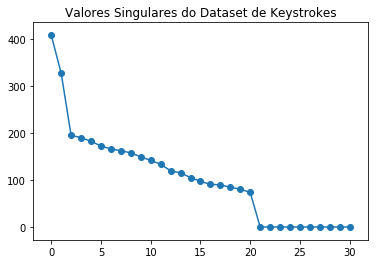

In [8]:
plt.plot(Sigma)
plt.scatter(np.arange(31), Sigma)
plt.title("Valores Singulares do Dataset de Keystrokes")
plt.show()

Olhando para esse gráfico, vemos de imediado que a partir da dimensão ideal 20 as outras dimensões praticamente não contribuem para a informação real dos dados. Em termos um pouco mais formais, praticamente não há variação dos dados ao longo das dimensões superiores à vigésima.

Se lembrarmos quais as métricas gravadas durante a construção do dataset, essa conclusão faz sentido. A métrica `Down-Down` é redundante quando considerando as outras. Afinal, o tempo de `Hold` somado a `Up-Down` é exatamente o tempo medido por `Down-Down`. Isso significa que $\frac{1}{3}$ das métricas coletadas por tecla é redundante. Dessa forma, se tínhamos 31 valores originalmente medidos, acabamos com apenas 20 valores que realmente contribuem para o dado.

Mais do que isso, é possível notar que as duas primeiras dimensões contribuem com a maior parte da informação dos dados. A partir da terceira, as dimensões ficam progressivamente menos relevantes de forma gradual.

Isso tudo indica que nosso gráfico em 2D dos pontos conterá uma boa parte da informação do dataset original. Portanto será uma boa visualização dos dados.

Para fazermos esse gráfico em 2D dos pontos, basta lembrarmos da interpretação das matrizes resultantes da decompoisção. Queremos levar nossos pontos ao espaço ideal e ignorar todas as dimensões exceto as duas primeiras.

O primeiro passo pode ser facilmente feito apenas com a matriz $U$ - afinal ela é a responsável por levar os pontos para o espaço ideal. Em seguida, basta zerarmos os valores singulares indesejáveis da matriz $\Sigma$ que zeraremos as coordenadas indesejadas dos pontos.

In [9]:
reduced_sigma = np.zeros((U.shape[1], Sigma.shape[0]))
reduced_sigma[0,0] = Sigma[0]
reduced_sigma[1,1] = Sigma[1]
print("Matriz Sigma Reduzida:\n",reduced_sigma, end="\n\n")
print("Dimensões de Sigma Reduzida:",reduced_sigma.shape)

Matriz Sigma Reduzida:
 [[ 407.97342532    0.            0.         ...,    0.            0.            0.        ]
 [   0.          326.96957765    0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 ..., 
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]]

Dimensões de Sigma Reduzida: (20400, 31)


Como queremos ficar no espaço ideal, basta não incluirmos a matriz $V^T$ - cuja função é trazer os pontos de volta ao espaço original.

In [10]:
reduced_keystrokes = U @ reduced_sigma
print(reduced_keystrokes)
print(reduced_keystrokes.shape)

[[ 0.79661649 -3.14352362  0.         ...,  0.          0.          0.        ]
 [ 7.33690199  2.98459802  0.         ...,  0.          0.          0.        ]
 [-0.41674256  3.11857179  0.         ...,  0.          0.          0.        ]
 ..., 
 [-1.29789951 -1.33182584  0.         ...,  0.          0.          0.        ]
 [ 0.54700926 -1.83758573  0.         ...,  0.          0.          0.        ]
 [ 1.03072995 -1.17526715  0.         ...,  0.          0.          0.        ]]
(20400, 31)


Como podemos ver, zeramos as coordenadas menos relevantes com sucesso. Basta então usarmos as que sobraram para desenhar o gráfico.

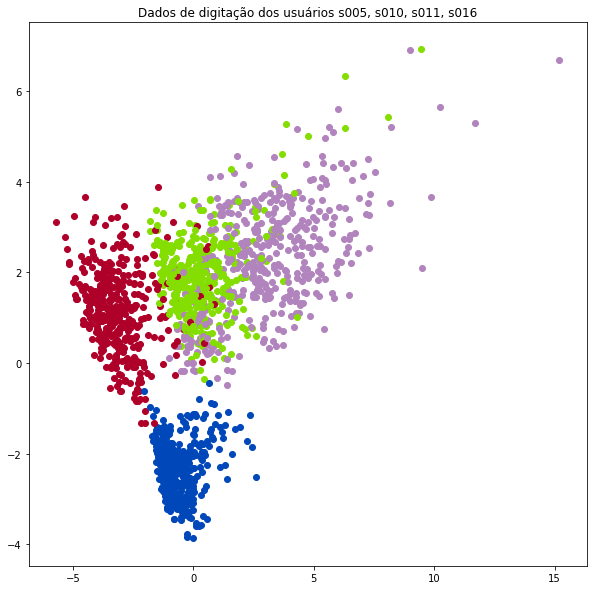

In [11]:
colors = {"s002": "#E32636", "s003": "#B0BF1A", "s004": "#7CB9E8", "s005": "#84DE02", "s007": "#EFDECD", "s008": "#00308F", "s010": "#0048BA", "s011": "#AF002A", "s012": "#C9FFE5", "s013": "#72A0C1", "s015": "#C46210", "s016": "#B284BE", "s017": "#E52B50", "s018": "#9F2B68", "s019": "#F19CBB", "s020": "#AB274F", "s021": "#D3212D", "s022": "#3B7A57", "s024": "#FFBF00", "s025": "#FF7E00", "s026": "#3B3B6D", "s027": "#391802", "s028": "#804040", "s029": "#D3AF37", "s030": "#34B334", "s031": "#FF8B00", "s032": "#FF9899", "s033": "#431C53", "s034": "#B32134", "s035": "#FF033E", "s036": "#CFCFCF", "s037": "#551B8C", "s038": "#F2B400", "s039": "#9966CC", "s040": "#A4C639", "s041": "#F2F3F4", "s042": "#CD9575", "s043": "#665D1E", "s044": "#915C83", "s046": "#841B2D", "s047": "#FAEBD7", "s048": "#008000", "s049": "#66B447", "s050": "#8DB600", "s051": "#FBCEB1", "s052": "#00FFFF", "s053": "#7FFFD4", "s054": "#D0FF14", "s055": "#C0C0C0", "s056": "#4B5320", "s057": "#3B444B"}
reduced_keystrokes_ = reduced_keystrokes[:,:2]

vis_users = ["s005", "s010", "s011", "s016"]
plt.figure(figsize=(10,10))
for i, point in enumerate(reduced_keystrokes_):
    #Para facilitar a visualização, faremos o plot de apenas quatro usuários
    if recordings[i][0] in vis_users:
        plt.scatter(point[0], point[1], c=colors[recordings[i][0]])
plt.title("Dados de digitação dos usuários {} (SVD)".format(", ".join(vis_users)))
plt.show()

Observando o gráfico, vemos que a redução de dimensionalidade realmente funcionou. Usando a técnica de SVD conseguimos visualizar as diferenças nos padrões de digitação das pessoas utilizadas na criação do dataset.

Podemos ver que usando apenas duas dimensões não é sempre óbiva a distinção de cada par de usuários. No exemplo do gráfico acima, vemos uma clara separação entre os usuários azul, vermelho escuro e verde - com pontos concentrados em regiões diferentes do espaço. Já o usuário roxo, se mistura consideravelmente com o verde. Isso pode ser reflexo de uma possível proximidade do modo como ambos digitam, ou simplesmente uma limitação da visualização em 2D do dataset.

Podemos, por fim, tentar estimar a grosso modo quanta informação retemos ao simplificar os dados para 2D. Para isso, podemos usar os valores singulares obtidos em $\Sigma$. A ideia é simplesmente verificar a proporção das dimensões retidas em relação ao total.

In [12]:
retained_info = (Sigma[0] + Sigma[1]) / np.sum(Sigma)
print("Estimativa de informação retida: {}%".format(100*retained_info))

Estimativa de informação retida: 22.684216838113194%


Diminuindo o espaço dos pontos do dataset da forma que fizemos, somos capazes de reter um pouco mais de 22% da informação do dado original. Essa estimativa não pode ser levada tão literalmente, mas ajuda a entender o que estamos preservando.

Mesmo com apenas um quinto da informação original, ainda somos capazes de visualmente discernir alguns usuários. Isso realmente é um indicativo motivador para a próxima tarefa: classificação.

### Autoencoder

Vimos uma forma de redução de dimensionalidade, o SVD. Entretanto, essa decomposição não é a única forma de se reduzir as dimensões de dados. Existe outro método muito popular conhecido como _Autoencoder_.

A técnica de _Autoencoder_ foi desenvolvida com a popularização de redes neurais no cenário acadêmico. A proposta consiste de uma ideia muito simples. Criamos uma rede neural dividida em duas partes: um _encoder_ e um _decoder_. O encoder é responsável por pegar o dado no espaço original e levá-lo para um espaço latente (_embedding space_). O decoder faz justamente o oposto, ou seja, recebe como entrada um vetor no espaço latente e o converte de volta ao espaço original.

<center>
```
embedding = encoder(dado original)
dado reconstruido = decoder(embedding)
```
</center>

A ideia é treinar a rede para encontrar o melhor espaço latente possível para representar os dados, de forma que o máximo de informação seja preservada. Afinal, é desejável que sejamos capazes de reconstruir os dados originais a partir da representação codificada. Em termos mais concretos, estamos tentando minimizar a diferença entre o dado reconstruido e o dado original controlando as funções de _encoding_ e _decoding_.

$$
    decoder, encoder = \arg \min_{d,e}{\lVert X - d(e(X)) \rVert ^2}
$$

O espaço de embedding pode ser arbitrariamente escolhido, mas como nosso objetivo é realizar uma redução de dimensionalidade, é interessante escolhermos um espaço com dimensão menor. Mais especificamente, queremos um espaço em 2D para fazermos um gráfico representativo do dataset.

Para isso, construimos uma rede neural que afunila e depois expande os dados. A camada inicial da rede é da dimensão original do dado. A partir da primeira, as camadas ficam progressivamente menores, forçando uma representação mais densa de nossos dados. Quando chegamos na dimensão desejada, começamos o processo de reconstrução do dado. A partir desse ponto, as camadas ficam progressivamente maiores até atingirem o tamanho original.

![Estrutura de um Autoencoder](Autoencoder_structure.png)

Construiremos uma rede com a mesma quantidade de camadas que a imagem acima mostra. Aproveitando que já calculamos os valores singulares previamente usando o SVD, vemos que realmente só precisamos de 20 dimensões para representar fielmente nossos dados. Dessa forma, podemos supor que é uma boa escolha fazer as camadas intermediárias entre o dado original e a representação 2D ser de tamanho 20.


<center>
```
dado (31D) -> dado (20D) -> dado (2D) -> dado (20D) -> dado (31D)
```
</center>

O fato de termos camadas intermediárias entre a representação 2D e a original ajuda a dar mais flexibilidade para manipulação por parte da rede.

#### Construindo a rede
Para construirmos essa rede, utilizaremos a biblioteca _Tensorflow_. Essa biblioteca de baixo nível permite a criação de redes neurais com uma facilidade maior, afinal já possui funções muito utilizadas implementadas.

No trecho de código abaixo definimos a rede respeitando as camadas descritas acima.

In [13]:
#Especifica que dispositivo rodará a computação
with tf.device("/device:CPU:0"):
    
    # Cria uma variável (placeholder) cujos valores serão posteriormentes preenchidos
    # com os dados do dataset. Essa variável armazena os dados na dimensão original.
    x = tf.placeholder(tf.float32, shape=[None, 31])

    
    # Definimos a primeira camada da rede aqui
    # A variável encoder_W1 é a matriz de pesos que leva o dado original em 31D para a
    # representação intermediária em 20D.
    # A variável encoder_b1 é somada à representação em 20D para permitir a translação
    # nesse novo espaço.
    encoder_W1 = tf.get_variable("e_W1", shape=[31, 20], initializer=tf.contrib.layers.xavier_initializer())
    encoder_b1 = tf.Variable(tf.zeros([20]), name="e_b1")

    # A variável embedding_20D efetivamente utiliza encoder_W1 e encoder_b1 para calcular
    # a representação do vetor em espaço 20D.
    embedding_20D = tf.nn.relu(tf.matmul(x, encoder_W1) + encoder_b1)

    
    # De forma semelhante à camada anterior, as variáveis encoder_W2 e encoder_b2 levam
    # o vetor 20D para o espaço 2D desejado.
    encoder_W2 = tf.get_variable("e_W2", shape=[20, 2], initializer=tf.contrib.layers.xavier_initializer())
    encoder_b2 = tf.Variable(tf.zeros([2]), name="e_b2")

    # A variável embedding_2D armazena a representação em 2D do nosso dado original
    # convertendo a representação intermediária em 20D para a final em 2D.
    embedding_2D = tf.matmul(embedding_20D, encoder_W2) + encoder_b2
    
    # A variável embedding_2D_activated passa a representação em 2D do vetor por uma função
    # de ativação para dar prosseguimento ao resto da rede (reconstrução do dado original).
    embedding_2D_activated = tf.nn.sigmoid(embedding_2D)

    
    # Queremos agora voltar com as dimensões do dado representado em 2D. Para isso, de forma
    # parecida com a parte de compressão da rede, utilizaremos decoder_W1 e decoder_b1 para
    # levar o vetor 2D a um espaço intermediário em 20D.
    decoder_W1 = tf.get_variable("d_W1", shape=[2, 20], initializer=tf.contrib.layers.xavier_initializer())
    decoder_b1 = tf.Variable(tf.zeros([20]), name="d_b1")

    # A variável reconstruction_20D armazena a reconstrução no espaço intermediário 20D.
    reconstruction_20D = tf.nn.relu(tf.matmul(embedding_2D_activated, decoder_W1) + decoder_b1)

    # Por fim, as variáveis decoder_W2 e decoder_b2 fazem a reconstrução final dos dados.
    decoder_W2 = tf.get_variable("d_W2", shape=[20, 31], initializer=tf.contrib.layers.xavier_initializer())
    decoder_b2 = tf.Variable(tf.zeros([31]), name="d_b2")

    # A variável reconstruction_31D guarda a reconstrução feita pelo decoder e idealmente
    # representa o dado original do dataset.
    reconstruction_31D = tf.matmul(reconstruction_20D, decoder_W2) + decoder_b2

    # Utilizamos o erro quadrado médio como métrica de custo da rede.
    loss = tf.reduce_mean(tf.pow(x - reconstruction_31D, 2))

    # A variável train_step é responsável por fazer uma atualização de pesos através de
    # backpropagation.
    train_step = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)

Os comentários no código acima explicam a construção da rede. Todavia vale a pena ressaltar algumas partes com mais detalhes. A variável de reconstrução final, `reconstruction_31D`, é a variável que compararemos com o dado original para verificarmos a integridade da reconstrução. Essa medida é feita com base no erro quadrático.

$$
    Erro = \lVert X - d(e(X)) \rVert ^2
$$

No código, entretanto, não utilizamos apenas um exemplo por vez durante o treinamento. Utilizamos um _batch_ com vários exemplos para guiar uma única atualização de pesos da rede. Para isso, a nossa função de erro deve incorporar todos esses exemplares utilizados.

$$
    Erro = \frac{1}{m} \sum_{i = 0}^{m} \lVert X_i - d(e(X_i)) \rVert ^2
$$

Nesse caso, $m$ representa o número de exemplos no batch. Dessa forma, passamos a medir o erro médio de um conjunto de exemplos. Isso nos ajuda a ter uma noção melhor de como o autoencoder se comporta em diversos exemplos. Afinal, potenciais _outliers_ serão suavizados quando tirarmos o erro mẽdio.

Outros aspectos relevantes da construção da rede são a inicialização, as funções de ativação e o otimizador.

Os pesos das matrizes da rede são inicializados de acordo com a [_Inicialização de Xavier _](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Essa inicialização ajuda a controlar a magnitude dos pesos para preservar a variância entre o vetor de entrada e o de saída dessa camada.

As funções de ativação da rede foram escolhidas dentre as mais populares por tentativa e erro até encontrar uma combinação boa. É importante ressaltar que a representação em 2D dos pontos é tirada antes da aplicação da função de ativação. Isso permite a utilização de qualquer número real pela representação. Caso utilizássemos alguma função de ativação, restringiríamos essas possibilidades ([sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) limita a valores entre 0 e 1, [tanh](https://pt.wikipedia.org/wiki/Tangente_hiperb%C3%B3lica) limita entre -1 e 1, [relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) limita a números positivos). Da mesma forma, na camada final, não podemos aplicar uma função de ativação. Afinal, como os dados iniciais não possuem nenhuma limitação interínseca, estaríamos impossibilitando a reconstrução perfeita e piorando a reconstruição atingida pela rede.

Por fim, a rede utiliza o Adam como técnica de atualização de pesos. O Adam foi desenvolvido em cima de outras técnicas de backpropagation como o RMSProp, AdaGrad e Momentum. De forma simplificada, o otimizador é uma versão menos ingênua do _Stochastic Gradient Descent_ tradicional que torna o processo mais eficaz e contorna uma série de limitações presentes no SGD original. Mais informações sobre otimizadores podem ser encontradas [aqui](http://ruder.io/optimizing-gradient-descent/).


#### Treinamento

Com a estrutura da rede montada, prosseguimos para o o preparo do ambiente de treinamento. O primeiro passo é separar o dataset em conjunto de treino e conjunto de teste. O conjunto de treino será utilizado para alimentar a parte de atualização dos pesos da rede. Já o conjunto de teste será usado para a verificação de performance do autoencoder. É importante que esses conjuntos sejam disjuntos, pois se houvesse compartilhamento de elementos, a rede poderia simplesmente decorar cada exemplo de treino e se tornar inviesada. Ou seja, não saberíamos se a rede efetivamente aprendeu uma representação que generalize bem para qualquer ponto da distribuição do dataset, ou se apenas funciona bem nos exemplos mostrados durante o treino.

In [14]:
split_data_idx = 20000
train_data = norm_keystrokes[:split_data_idx]
test_data = norm_keystrokes[split_data_idx:]

Para nos ajudar no treinamento em batches, passemos a definir uma função que entrega o próximo batch conforme progredimos no treinamento. Lembre-se que os dados já foram embaralhados no tratamento inicial do dataset, portanto não é necessário embaralhá-los novamente aqui. 

In [15]:
def next_batch(size, i):
    return train_data[i*size:(i+1)*size]

Para salvarmos os pesos da rede para uso posterior, o Tensorflow nos disponibiliza um objeto `Saver` que armazena toda informação necessária para a recontrução da rede neural atual. Tiraremos proveito desse objeto para mantermos sempre os melhores pesos encontrados.

Como o processo de otimização da rede se dá de forma estocástica, não é garantido que os pesos após a próxima atualização sejam melhores que os atuais. Podemos por exemplo ter escolhido um batch ruim para o treino em determinada rodada. Na média, a rede progride em direção ao ótimo (mesmo que local), mas a cada iteração isso nem sempre é verdade. Por isso, vamos nos aproveitar do objeto `Saver` para salvar os pesos somente quando forem melhores do que os últimos salvos. Compararemo-nos através das losses obtidas com cada um.  

In [16]:
saver = tf.train.Saver()

Finalmente, chegamos ao treino propriamente dito da rede.

In [17]:
# Utilizaremos a variável losses para armazenar os custos ao longo do treinamento.
losses = []

# min_loss guardará o custo do melhor conjunto de pesos até agora.
# Utilizaremos isso para decidir quando salvarmos os pesos.
min_loss = float("inf")

#Inicializamos uma sessao do tensorflow para podermos utilizar as variáveis criadas
# anteriormente.
with tf.Session() as sess:
    
    # Essa função efetivamente chama a inicialização das variáveis criadas.
    # As inicializa de acordo com as especificações na declaração.
    sess.run(tf.global_variables_initializer())
    
    # Vamos treinar a rede por 100 épocas.
    # Cada época é uma passagem completa pelo conjunto de treino.
    for epoch in range(100):
        # Como o conjunto de treino é composto de 20000 exemplos, faremos o
        # treinamento em 200 batches de tamanho 100 cada um.
        for i in range(200):
            
            # Utilizamos nossa função para pegar o próximo batch
            batch = next_batch(100, i)
            
            # Atualizamos os pesos da rede ao executar train_step.
            # Em seguida pegamos o valor de custo atual para
            # armazenamento e comparação futura.
            _, current_loss = sess.run([train_step, loss], feed_dict={x:batch})
            
            # Armazenamos a loss desse batch
            losses.append(current_loss)

            print("Ep {}: Batch #{} - Loss: {}".format(epoch, i, losses[-1]))
            
            # Caso o custo atual seja menor que a menor até então, encontramos 
            # pesos melhores para a rede, e portanto devemos salvá-los
            if losses[-1] < min_loss:
                # Atualizamos o valor do melhor custo 
                min_loss = losses[-1]
                
                # Salvamos os pesos da rede em um arquivo
                save_path = saver.save(sess, "./weights_autoencoder_no_final_relu/model_e{}b{}_{}.ckpt".format(epoch, i, time.time()))
                print("Model saved in file: %s" % save_path)

Output omited for brevity.

In [18]:
print("Menor custo obtido durante o treino: {}".format(min(losses)))

Menor custo obtido durante o treino: 0.41418716311454773


Depois de treinar a rede por 100 épocas usando batches de tamanho 100, esperamos ter uma rede capaz de codificar nossos dados de 31 dimensões em apenas duas. Observando as `losses`, vemos que conseguimos um custo mínimo de 0.41418716311454773. Isso é bom? Ruim? É difícil entender exatamente o que esse valor significa apenas olhando para ele. Um jeito melhor de avaliar o desempenho da rede para humanos seria olhar o gráfico 2D propriamente dito.

INFO:tensorflow:Restoring parameters from ./weights_autoencoder_no_final_relu/model_e99b118_1516716900.9840117.ckpt
Model restored.


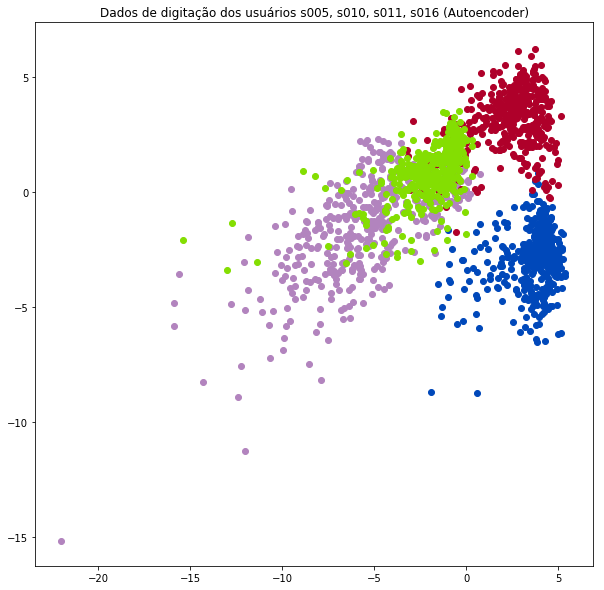

In [19]:
# Para não deixar o gráfico visualmente poluido, faremos o plot apenas
# dos dados de 4 usuários.
plot_points_31D = {"s005":[], "s010":[], "s011":[], "s016":[]}
plot_points_2D = {"s005":[], "s010":[], "s011":[], "s016":[]}
for i, point in enumerate(norm_keystrokes):
    if recordings[i][0] in vis_users:
        plot_points_31D[recordings[i][0]].append(point)

# Novamente, para acessar os valores das variáveis do tensorflow,
# precisamos iniciar uma Session.
with tf.Session() as sess:
    # Restaura os pesos relativos ao menor custo encontrado durante o treinamento.
    # Isso garante que estamos usando o melhor conjunto de pesos encontrados e não
    # o último.
    saver.restore(sess, "./weights_autoencoder_no_final_relu/model_e99b118_1516716900.9840117.ckpt")
    print("Model restored.")
    
    # Para cada usuário, armazena as coordenadas em 2D de cada ponto seu.
    for user in plot_points_31D:
        points_31D = np.array(plot_points_31D[user])
        points_2D = sess.run(embedding_2D, feed_dict={x:points_31D})
        plot_points_2D[user] = points_2D

# Configura parâmetros do gráfico e o desenha na tela.
plt.figure(figsize=(10,10))
for user in plot_points_2D:
    plt.scatter(plot_points_2D[user][:,0], plot_points_2D[user][:,1], c=colors[user])
plt.title("Dados de digitação dos usuários {} (Autoencoder)".format(", ".join(vis_users)))
plt.show()

Podemos observar que o autoencoder encontrou um espaço de representação 2D diferente do encontrado pelo SVD, entretanto, ambas as representações apresentam similaridades. Da mesma forma que o espaço do SVD, o espaço do Autoencoder, separa bem os usuários azul, vermelho e verde. Novamente pecando na separação do roxo com o verde. É difícil dizer se os dados estão mais ou menos separados quando comparado ao SVD. Entretanto podemos notar que o Autoencoder encontrou uma representação mais dispersa dos dados.

Podemos verificar essa dispersão observando a própria distribuição dos pontos na imagem e notando as escalas dos eixos. O eixo Y do gráfico do espaço do Autoencoder varia de 6 a -15, que é justamente a variação do eixo X do gráfico da projeção do SVD. Podemos inclusive nos perguntar se teriam encontrado o mesmo vetor para projetar os dados nessa direção. Analisando o eixo X do gráfico do Autoencoder, vemos que este varia de -23 a 7. Em contrapartida, o do SVD varia de 7 a -4. Isso mostra que realmente os dados na codificação do Autoencoder estão mais espalhados do que na representação do SVD.

## Classificação

Agora que temos um melhor entendimento dos dados do dataset, passemos à parte de classificação de dados.

Gostaríamos de ser capazes de ao receber um vetor em 31D representando a digitação de um usuário identificarmo-no. Isso caracteriza um problema de classificação, ou seja, temos classes definidas - nesse caso, cada usuário é uma classe - e gotaríamos de escolher a mais apropriada tendo em vista o input recebido.

### Regressão Logística

Existem diversos algoritmos capazes de realizar a tarefa de classificação. Um algoritmo bem conhecido é a **Regressão Logística**. A Regressão Logística é capaz de classificar um vetor numérico arbitrário como pertencente a uma classe ou não.

<img src="logistic_regression_diagram.png" width="400px"> 

A ideia da regressão logística é converter o vetor de entrada em um único número e verificar se o esse valor passou de determinado _threshold_. Caso tenha passado, classificamos o vetor de entrada como pertencente à classe. Caso o contrário, classificamo-no como não pertencente.

$$
    classe = 
    \begin{cases}
        1,& \text{se } w^Tx\geq threshold\\
        0,& \text{se } w^Tx\lt threshold
    \end{cases}
$$

Para converter o vetor de entrada em um único número, fazemos o produto interno do mesmo com um vetor de pesos $w$. Na definição de $classe$ acima, $1$ representa "pertencer à classe", enquanto $0$ representa "não pertencer à classe". Dessa forma se o produto $w^Tx$ for alto o suficiente, $x$ será classificado como pertencente à classe.

Resta então saber como encontrar o vetor de pesos $w$. Gostaríamos que $w$ fosse tal que permita a classificação correta de vetores em relação ao pertencimento da classe em questão. Existem diversas formas que podemos proceder com essa tarefa. A mais comum quando trabalhando com regressão logística é o _Gradient Descent_. Como vimos em aula, calculamos o gradiente de uma função de custo em relação às variáveis sobre as quais temos controle.

Para utilizar o _Gradient Descent_, precisamos definir uma função de custo para minimizar. Essa função deve refletir nosso desejo de acertar as classificações dos vetores de entrada. Assim, se estivermos acertando as classificações, os valores da função de custo devem ser baixos. Ao passo que, se errarmos as classificações devemos ter como retorno um valor mais alto.

$$
    Custo = -y \cdot log(\hat{y}) - (1-y) \cdot log(1-\hat{y})
$$

Como função de custo para a regressão logística, utilizamos a função acima, conhecida como _cross-entropy_. Na definição acima, $y$ representa a classe real do vetor, enquanto $\hat{y}$ representa a classe prevista pela regressão logística.

Podemos analisar os diferentes cenários que podemos encontrar na função de custo. Suponhamos que escolhemos um vetor pertencente à classe em questão - ou seja $y$ tem o valor de $1$. Se a regressão logística acertar a classificação, ficaremos com:
$$
    Custo = -1 \cdot log(1) - (1 - 1) \cdot log(1 - 1)
$$
$$
    Custo = -1 \cdot 0 - 0 \cdot log(0)
$$
$$
    Custo = 0 - 0
$$

$$
    Custo = 0
$$

O custo nesse caso será zero. Note que tomamos a liberdade de avaliar $0 \cdot log(0)$ como zero nesse caso. Agora, se a previsão estivesse errada, teríamos outro cenário:

$$
    Custo = -1 \cdot log(0) - (1 - 1) \cdot log(1 - 0)
$$
$$
    Custo = -1 \cdot log(0) - (0) \cdot log(1)
$$

$$
    Custo = -1 \cdot log(0) - 0
$$

$$
    Custo = -log(0)
$$

No limite, $-log(0)$ explode para o infinito. Portanto, errar a classe tem o pior custo possível, infinito.
O mesmo ocorre quando a classe do vetor e 0 ($y = 0$).

Dessa forma, essa função realmente reflete o que queremos em uma função de custo.

Podemos, então, prosseguir e calcular o gradiente da função de custo em relação a $w$. Afinal $w$ é o parâmetro que podemos controlar para tentar diminuir o erro.

$$
    \frac{\partial Custo}{\partial w} = \frac{\partial}{\partial w}(-y \cdot log(\hat{y}) - (1-y) \cdot log(1-\hat{y}))
$$

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} \cdot \frac{\partial \hat{y}}{\partial w} - \frac{(1-y)}{1-\hat{y}} \cdot \frac{\partial \hat{y}}{\partial w}\bigg{)}
$$

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \frac{\partial \hat{y}}{\partial w}
$$

Rapidamente, entretanto, encontramos um problema. Não podemos computar a derivada parcial de $\hat{y}$ em relação a $w$, pois a relação entre eles não é diferenciável.

Para contornar esse problema, modificaremos um pouco a forma como $\hat{y}$ é calculado. Comecemos por reescrever a função em relação ao posicionamento do threshold. Para simplificar a expressão, vamos definir $b = - threshold$.

$$
    \hat{y} = 
    \begin{cases}
        1,& \text{se } w^Tx + b \geq 0\\
        0,& \text{se } w^Tx + b \lt 0
    \end{cases}
$$

Isso não elimina a descontinuidade da função, mas a centraliza em zero. Se observarmos o gráfico dessa função, obteremos o seguinte.

![Função Heaviside](step.png)

O que queremos aqui é substituir essa função degrau por algo que mantenha o formato geral da função - para manter sua propriedade de classificação, mas que seja diferenciável. Um candidato muito comumente usado é a função _sigmoid_ (também conhecida como _função logística_) e é dado pela seguinte fórmula.

$$
    sigmoid(z) = \frac{1}{1 + e^{-z}}
$$

![Função Logística](sigmoid.png)

Visivelmente, as funções são parecidas. Como desejávamos, o sigmoid é diferenciável. Representemos a função sigmoid por $\sigma$. Se atualizarmos a definição de $\hat{y}$, ficamos com:

$$
    \hat{y} = \sigma(w^T x + b)
$$

Agora, podemos prosseguir com a diferenciação que interrompemos acima.

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \frac{\partial \hat{y}}{\partial w}
$$

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \frac{\partial}{\partial w}\sigma(w^T x + b)
$$

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \sigma'(w^T x + b) \cdot \frac{\partial}{\partial w}(w^T x + b)
$$

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \sigma'(w^T x + b) \cdot x
$$

Entretanto, além de $w$, também podemos alterar o valore de $b$ para melhorar as classificações. Para isso também precisaremos calcular o gradiente da função de custo em relação a $b$. O processo se dá de forma muito parecida com a parcial em $w$ e obtemos um resultado parecido também.

$$
    \frac{\partial Custo}{\partial w} = -\bigg{(}\frac{y}{\hat{y}} - \frac{(1-y)}{1-\hat{y}}\bigg{)} \sigma'(w^T x + b)
$$

#### Construindo o modelo

Tendo os cálculos feitos, em tese podemos prosseguir implementando o algoritmo. Entretanto, devemos lembrar que a regressão logística permite dizer se um vetor pertence ou não a uma classe. Para realizarmos a tarefa originalmente proposta de classificar o vetor dentre 51 classes, precisamos modificar um pouco a abordagem da regressão logística.

Em vez de usarmos apenas um vetor de pesos $w$, podemos usar 51 vetores (e escalares $b$). Com isso teremos 51 regressões logísticas dizendo se o dado pertence ou não a seu respectivo usuário. Dessa forma, esperamos que todos os classificadores digam que o usuário não pertence à classe, exceto um - o da classe correta.

Comecemos então por definir as variáveis responsáveis por armazenar os pesos e os biases.

In [20]:
np.random.seed(1234)
W = {user:np.random.rand(31) - 0.5 for user in users}
b = {user:np.random.rand(1) - 0.5 for user in users}

Em seguida, definimos as funções que serão usadas no algoritmo principal

In [21]:
def sigmoid(x, derivative=False):
    # Definimos o sigmoid e dua derivada na mesma função para facilitar
    # seu uso.
    if derivative:
        s = sigmoid(x)
        return s * (1-s)
    return 1/(1 + np.exp(-x))

In [22]:
def calc_loss(y, y_):
    # Calcula cross-entropy usando y como resposta real e y_ como previsão
    return np.mean(-y * np.log(y_ + 1e-8) - (1-y) * np.log(1-y_ + 1e-8))

In [23]:
def forward_pass(x, W, b):
    # Calcula a classe baseado em um vetor de pesos e um escalar de víes
    # Note que nessa função aceitam-se matrizes para W e vetores para b,
    # afinal estamos trabalhando com batches e não com um exemplo de
    # cada vez.
    z = x.dot(W) + b
    y_ = sigmoid(z)
    return y_, z

In [24]:
def backward_pass(x, y, W, b):
    # Responsável por calcular as derivadas parciais para W e b.
    # Funciona com batches também, nesse caso retornando a média
    # dos gradientes.
    y_, z = forward_pass(x, W, b)
    dLdb = (-y/(y_ + 1e-8) + (1-y)/(1-y_ + 1e-8)) * sigmoid(z, True)
    dLdW = np.zeros((dLdb.shape[0], 31))
    for i, el in enumerate(dLdb):
        dLdW[i] = x[i] * el
    dLdW = np.mean(dLdW, axis=0)
    dLdb = np.mean(dLdb, axis=0)
    return dLdW, dLdb

In [25]:
def next_batch(size, user):
    # Retorna um batch retirado do conjunto de treino.
    # A cada vez que a função é chamada, um novo batch
    # é retornado até todo o dataset ser coberto.
    for i in range(train_data.shape[0] // size):
        l = (train_labels[i*size:(i+1)*size] == user).astype(np.float64)
        k = train_data[i*size:(i+1)*size]
        yield k,l

In [26]:
def test_accuracy(user, W, b):
    # Função que mede a acurácia do modelo em um conjunto de teste.
    predictions = forward_pass(test_data, W, b)[0]
    accuracy = np.mean((predictions > 0.5) == (test_labels == user))
    return accuracy, predictions

Os dados de entrada da regressão logística já foram separados em treino e teste. Entretanto, para o treinamento da tarefa de classificação, vamos precisar das labels correspondentes de cada exemplo.

In [27]:
train_labels = recordings[:split_data_idx,0]
test_labels = recordings[split_data_idx:,0]

#### Treinamento do modelo

Passemos, então, à fase de treino.

In [28]:
# Lista que armazenará o custo ao longo do treino para cada usuário.
test_loss = {user:[] for user in users}

# Lista que armazenará as acurácias ao longodo treino para cada usuário.
test_accuracies = {user:[] for user in users}

# Definimos uma taxa de aprendizado para o Gradient Descent.
learning_rate = 1e-3

# Treinamos uma regressão linear de cada vez.
for user in users:
    # Treinaremos por 100 épocas.
    for epoch in range(100):
        # Cada época é composta por 200 batches de tamanho 100.
        for vs, ls in next_batch(100, user):
            # Testamos o desempenho do modelo atual para guardar no histórico.
            acc, predictions = test_accuracy(user, W[user], b[user])
            
            # Armazenamos a acurácia atual.
            test_accuracies[user].append(100* acc)
            
            # Armazenamos o custo atual.
            test_loss[user].append(calc_loss(predictions, (test_labels == user).astype(np.float64)))
            print("User: {} - Ep: {} - Acc: {}% - Loss: {}".format(user, epoch, test_accuracies[user][-1], test_loss[user][-1]))
            
            # Calculamos os gradientes para realizar o Gradient Descent.
            dW, db = backward_pass(vs, ls, W[user], b[user])
            
            # Atualizamos os pesos e baises do modelo.
            W[user] -= dW * learning_rate
            b[user] -= db * learning_rate

Output omited for brevity.

#### Avaliação da solução

Ao longo do treino, armazenamos as acurácias e custos encontrados por cada modelo de cada usuário. Tendo essas informações, podemos gerar gráficos e analisar a evolução do treinamento.

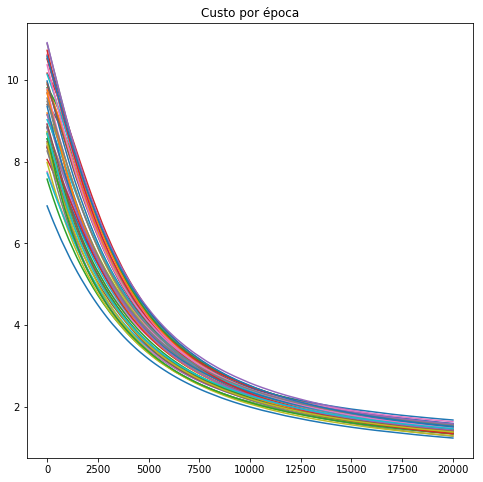

In [29]:
plt.figure(figsize=(8,8))
for user in users:
    plt.plot(test_loss[user])
plt.title("Custo por época")
plt.show()

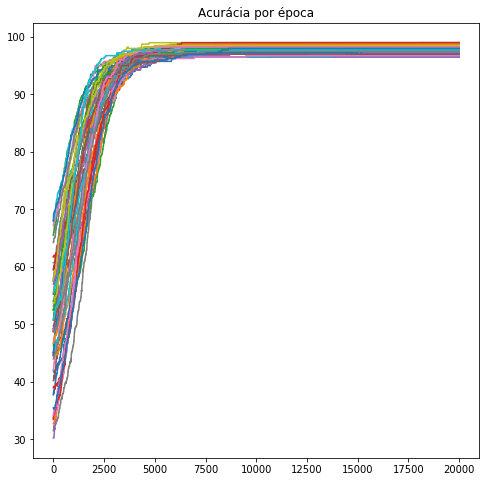

In [30]:
plt.figure(figsize=(8,8))
for user in users:
    plt.plot(test_accuracies[user])
plt.title("Acurácia por época")
plt.show()

Observando os gráficos, vemos que os modelos realmente aprenderam alguma coisa durante o treinamento. Todos se comportam de um modo semelhante. Todos os custos decrescem consideravelmente durante o treino, bem como as acurácias sobem até atingirem valores próximos a 100%.

Entretanto, essas medidas foram tiradas nas tarefas individuais de classificar um vetor como pertencente a determinado usuário ou não. Para termos uma noção melhor do desempenho dessa solução na tarefa real, precisamos de uma nova medida. É necessário medir a acurácia na classificação multiclasse.

Idealmente, apenas um dos modelos diria que o vetor pertence à sua classe. Todos os outros corretamente preveriam que o vetor não faz parte de suas classes. Entretanto, isso nem sempre é o caso, afinal o modelo é imperfeito. Podemos ter ocorrências de mais de um modelo prevendo o vetor de entrada como de sua classe, bem como nenhum vetor dizendo que o vetor pertence à sua classe.

Para resolver esses problemas, podemos simplesmente classificar o vetor de entrada como sendo pertencente ao modelo que resultar no maior valor de $\hat{y}$. Se lembrarmos que os valores possíveis de $\hat{y}$ são 0 e 1 - sendo 0 não pertencente à classe e 1 pertencente -, essa medida faz sentido. Afinal, quando mais próximo de 1, mais o classificador acredita que o vetor pertence à classe. Pegando o maior valor (limitado superiormente por devido ao sigmoid), estamos classificando o vetor com base no classificador que tem maior confiança de que o vetor pertence à sua classe.

In [31]:
multi_class_predictions = []
for user in users:
    _, predictions = test_accuracy(user, W[user], b[user])
    multi_class_predictions.append(predictions)
multi_class_predictions = np.array(multi_class_predictions)
multi_class_predictions = np.argmax(multi_class_predictions, axis=0)
multi_class_predictions = [users[c] for c in multi_class_predictions]

accuracy = np.mean([pred_class == test_labels[i] for i, pred_class in enumerate(multi_class_predictions)])
print("Acurácia multiclasse: {}".format(accuracy))    

Acurácia multiclasse: 0.575


Obtivemos uma acurácia média de 0.575 na tarefa de classificação multiclasse. Certamente é melhor que um classificador aleatório - cuja performance seria em torno de $\frac{1}{51}$, aproximadamente 0.02. Entretanto, essa performance não parece estar condizente com as acurácias individuais - próximas a 100% - vistas no gráfico.

O que está afetando a performance do classificador é a desproporção de classes vista durante o treinamento. Como treinamos cada modelo individualmente para dizer se um vetor de entrada pertence ou não à sua classe, durante o treinamento, a maioria dos exemplos vistos serão negativos. Afinal, como todas as classes possuem 400 exemplos, ao completar uma época, o modelo viu uma quantidade bem maior de exemplos que não pertencem à classe do que exemplos pertencentes. Isso cria um viés no classificador possibilitando conseguir uma acurácia alta mesmo aprendendo menos. Tendo a maioria dos exemplos como negativo, se um modelo chutar negativamente a maioria das vezes indiscriminadamente, ele ainda assim conseguirá uma boa acurácia.

Esse viés de classificar as entradas como negativas não permite uma boa acurácia na classificação multiclasse, todavia. Afinal, não queremos simplesmente saber se uma entrada pertence ou não a determinada classe, mas a qual classe ela pertence.

### Rede Neural

Poderíamos tentar mitigar o problema da regressão logística multiclasse tentando ajustar a proporção de classes no treinamento - seja, reduzindo as classes negativas ou repetindo as positivas até atingir algum tipo de equilíbro -, mas talvez seja mais interessante experimentarmos uma solução mais robusta.

Redes neurais são, de certa forma, uma evolução da regressão logística. A construção base se mantém a mesma, temos um vetor de pesos que tiramos o produto interno com a entrada e somamos um valor de _bias_. Entretanto, introduz-se a ideia de camadas. Em vez de simplesmente realizarmos a conversão de entrada para saída com um produto interno, podemos realizar mais operações.

O vetor $w$ da regressão logística se torna uma matris $W$ que leva um vetor em outro vetor; o viés $b$, que era um escalar, agora se torna um vetor; e a única operação de produto interno com soma se torna múltiplas operações em sequência - cada uma delas chamada de "camada da rede".

![Exemplo de uma rede neual](NN.png)

A rede neural é uma série de multiplicações de matrizes, somas e aplicações de não-linearidades em sequência. É um modelo bem mais poderoso que uma regressão logística - teoricamente é capaz de aproximar qualquer função provido de dados suficientes e uma arquitetura apropriada.

Utilizar uma rede neural para a classificação multiclasse é uma escolha extremamente apropriada, tendo em mente a flexibilidade a mais desse tipo de modelo. A arquitetura que utilizaremos para essa tarefa será a seguinte.

<center>
```
    entrada (31D) -> camada 1 (64D) -> camada 2 (51D) -> softmax (51D) -> classificação
```
</center>

Começamos com o vetor de entrada em 31 dimensões. Em seguida, vamos multiplicá-lo pela primeira matriz de pesos, $W_1$ e somarmos um _bias_ $b_1$. Por fim, aplicamos a não-linearidade (função de ativação) [ReLU (Rectified Linear Unit)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). O resultado dessas operações é uma representação intermediária, comumente referida como _camada_ (hidden layer). Agora repetiremos o processo com uma nova matriz, $W_2$, e _bias_, $b_2$ para gerarmos a segunda camada.

Pegando o resultado da segunda camada, aplicamos uma função conhecida como _softmax_, cujo papel é transformar valores arbitrários (qualquer número real) em probabilidades. No nosso caso da nossa tarefa, o resultado será um vetor de 51 posições, no qual cada posição representa a probabilidade do input ser da classe relativa àquela posição.

A fórmula do softmax é dada da seguinte forma:

$$
    softmax(x) = \frac{e^x}{\sum_{i = 1}^{51} e^{x_i}}
$$

De um modo mais intuitivo, o softmax recebe um vetor, faz a exponenciação de cada posição e divide cada posição pela soma de todas as posições. Isso faz com que possamos interpretar cada posição do vetor como uma probabilidade, afinal todas estão entre 0 e 1; e a soma resulta em 1.

A grande vantagem de utilizar o softmax, é o fato de que ele torna todas as posições do vetor interligadas. O custo das classificações se tornam conectados, fazendo com que todos os pesos sejam afetados pela classificação multiclasse. Isso é diferente da regressão logística multiclasse, em que se determinado vetor de entrada não foi classificado como a classe do modelo em questão, não importa sua classificação. A atualização dos pesos desse modelo é indiferente a qual classe o vetor pertence, caso não pertença à sua classe.

Isso faz com que o modelo realmente seja treinado para a tarefa de classificação multiclasse.

#### Arquitetura da Rede Neural

Novamente, usaremos o Tensorflow para construir e treinar essa rede neural. Comecemos por montar sua arquitetura.

In [32]:
# Devemos especificar o dispositivo que vai rodar as operações da rede.
with tf.device("/device:GPU:0"):
    # As variáveis x e y são placeholders para os vetores de entrada e
    # labels (classes) respectivamente.
    x = tf.placeholder(tf.float32, shape=[None, 31])
    y = tf.placeholder(tf.float32, shape=[None, 51])

    # W1 é a matriz que vai levar o input para um estado intermedirário
    # de processamento da rede.
    # b1 é o vetor responsável pela translação nesse novo espaço.
    W1 = tf.get_variable("W1", shape=[31, 64], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.zeros([64]), name="b1")
    
    # A variável layer1 armazena o valor da primeira camada da rede. Isso
    # significa que layer1 utiliza W1 e b1, bem como uma função de ativação
    # (não-linearidade) para computar o valor da primeira camada da rede.
    layer1 = tf.nn.relu(tf.matmul(x,W1) + b1)
    
    # Analogamente, W2 e b2 serão utilizados para gerar a segunda camada da
    # rede (camada final).
    W2 = tf.get_variable("W2", shape=[64, 51], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.zeros([51]), name="b2")

    
    # A variável y_ armazena a última camada da rede utilizando W2 e b2 para
    # calculá-la.
    y_ = tf.matmul(layer1,W2) + b2

    # Aplicamos o softmax em y_ e definimos como função de custo a cross-entropy.
    # O tensorflow tem uma versão otimizada para realizar essas operações em uma
    # única função (o que ajuda a reduzir o tempo de treino).
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_))

    # Por fim, definimos o otimizador como o Adam.
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

#### Treinamento da Rede Neural
Com a arquitetura definida, precisamos reformatar os dados de treino para que o Tensorflow os aceite.

As labels precisam estar no formato _one-hot_. O formato one-hot (ou _one-hot vector_) é simplesmente um vetor esparço no qual todas as posições são zero exceto por uma. Ele representa uma classe dentre as possíveis.

No nosso caso, temos 51 classes (usuários), então o tamanho desse vetor one-hot é 51 dimensões. Se queremos indicar o primeiro usuário, basta marcar a primeira posição do vetor com um $1$ e o resto com $0$. Da mesma forma, para indicarmos o segundo usuário, colocamos o $1$ na segunda posição. Assim funciona para todas as classes.

In [33]:
# Pegamos os índices para representar os usuários ao invés de seus
# nomes ("s002", "s003", ...)
labels = np.array([users.index(rec) for rec in recordings[:,0]])
print(labels)

[34, 30, 12, ..., 21, 42,  3]


Separamos os dados iniciais em dados para serem usados durante o treinamento e dados a serem utilizados para avaliar o desempenho da rede (conjunto de teste).

In [34]:
# Separa o dataset em conjunto treino e teste
train_data = keystrokes[:split_data_idx]
test_data = keystrokes[split_data_idx:]

Também é necessário redefinir a função que retorna os batches para o treino, visto que o Tensorflow funciona de um jeito um tanto diferente do que o implementado para a regressão logística.

In [35]:
def next_batch(size, i):
    # Recorta o bloco i de tamanho size de labels do
    # conjunto de treinamento.
    l = train_labels[i*size:(i+1)*size]
    
    # Prepara os vetores que viram a ser one-hot.
    # Um para cada exemplo do batch.
    onehot = np.zeros((len(l),51))
    
    # Itera sobre as labels, marcando 1 na posição
    # correta de cada vetor one-hot.
    for j, idx in enumerate(l):
        onehot[j][idx] = 1
        
    # Recorta os vetore de entrada do conjunto de
    # treinamento.
    k = train_data[i*size:(i+1)*size]
    
    # Retorna os vetores e labels correspondentes do
    # batch.
    return k, onehot.astype(float)

Finalmente, redefinimos a função para calcular a acurácia para utilizar a rede do tensorflow e o conjunto de teste formatado apropriadamente para avaliar o modelo. 

In [36]:
def test_accuracy():
    
    # Diz para o Tensorflow utilizar a GPU para realizar os cálculos
    # seguintes.
    with tf.device("/device:GPU:0"): 
        # Cada tf.argmax tem a função de escolher a posição do vetor
        # com maior probabilidade de ser a classe certa. O parâmetro
        # 1 passado na segunda posição indica o eixo no qual realizar
        # a operação. Dessa forma temos uma classe por exemplo do
        # batch.
        # Chamamos tf.equal para avaliar, a cada posição do vetor, se
        # os valores são iguais. Ou seja, se a previsão da rede é a
        # mesma da classe real.
        hits_and_misses = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
        
        # Convertemos o array de valores booleanos para valores
        # numéricos. False mapeia para 0 e True para 1. Dessa forma,
        # ao tirarmos a média do vetor, usando tf.reduce_mean, teremos
        # a acurácia de acertos do batch em questão.
        accuracy = tf.reduce_mean(tf.cast(hits_and_misses, tf.float32))
        
        # No código acima apenas criamos o grafo computacional que irá
        # calcular tudo que queremos. Chamando a função eval,
        # efetivamente obtemos o valor numérico desejado.
        # Retornamos esse valor.
        return accuracy.eval(feed_dict={x: test_data, y: test_labels_one_hot})

Agora, entramos na parte do treino. De forma bastante similar ao treinamento do Autoencoder, vamos treinar essa rede por 100 épocas. Cada época consiste de 100 batches de tamanho 200.

In [37]:
# Lista que armazenará as acurácias de teste durante o treinamento.
test_acc = []

# Variável utilizada para manter o controle de qual a maior acurácia
# encontrada até então.
max_acc = 0

# Inicializamos a Session do Tensorflow
with tf.Session() as sess:
    
    # Chamamos a função que efetivamente inicializa as variáveis criadas.
    sess.run(tf.global_variables_initializer())
    
    # Vamos treinar a rede por 100 épocas
    for epoch in range(100):
        # Cada época é composta de 200 batches de tamanho 100.
        for i in range(200):
            
            # Armazena o batch a ser processado no momento.
            batch = next_batch(100, i)
            
            # Atualiza os pesos da rede.
            train_step.run(feed_dict={x: batch[0], y: batch[1]})
            
            # Mede a acurácia da rede atual e a armazena na lista do
            # histórico.
            test_acc.append(test_accuracy())
            print("Ep {}: Batch #{} - Acc: {}%".format(epoch, i, 100*test_acc[-1]))
            
            # Caso a acurácia atual seja maior que a previamente maior,
            # salvamos os pesos atuais e atualizamos o valor de max_acc.
            if test_acc[-1] > max_acc:
                max_acc = test_acc[-1]
                save_path = saver.save(sess, "./weights/model_e{}b{}_{}.ckpt".format(epoch, i, time.time()))
                print("Model saved in file: %s" % save_path)

#### Avaliação da Rede
Como armazenamos as acurácias da rede durante o treino, podemos agora fazer um gráfico de sua evolução pelas épocas.

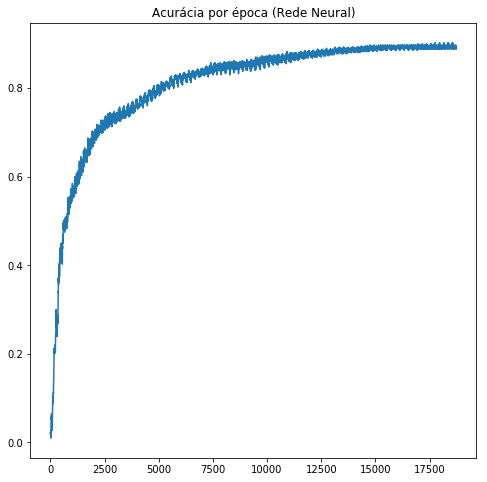

In [38]:
plt.figure(figsize=(8,8))
plt.plot(test_acc)
plt.title("Acurácia por época (Rede Neural)")
plt.show()

In [39]:
print("Maior acurácia obtida durante o treino: {}".format(max(test_acc)))

Maior acurácia obtida durante o treino: 0.9024999737739563


Observando o gráfico vemos uma clara superioridade do modelo de redes neurais em comparação com a solução de regressão logística. Rapidamente a rede atinge e supera a maior acurácia obtida com a regressão logística - em torno do batch 1000 a acurácia supera 57.5%. Vemos também que a rede consegue atingir uma acurácia respeitável de ~90%. Podemos dizer que a rede realmente aprendeu a classificar os usuários em relação a seus padrões de digitação.

Se tentarmos analisar a rede para determinar de onde veio esse ganho em desempenho, podemos chegar em dois pontos chave. O primeiro é a utilização do softmax. Como dito anteriormente, sua utilização causa a correlação da classificação com todos os pesos da rede. Independentemente de qual classe o exemplo em questão pertença, todos os pesos da rede neural contribuem para a classificação de tal exemplo. Dessa forma, temos um controle muito mais direto sobre como atualizar os pesos para garantir que as classificações sejam cada vez mais precisas.

O segundo ponto importante de se notar é a quantidade de camadas da rede. Por possuir duas camadas (uma _hidden layer_ e o output, ao invés de apenas o output), a rede tem mais flexibilidade para se adequar aos dados. Sabemos por avanços recentes na área de Machine Learning que aumentar a quantidade de camadas - tornando a rede mais profunda - aumenta incrivelmente a capacidade de aprendizado de uma rede. Mesmo essa só tendo duas camadas, foi o suficiente para saltar para 90% de acurácia.

## Conclusão

Respondendo a pergunta feita no início do documento, conseguimos discernir usuários a partir somente do seu modo de escrita. Essa conclusão a princípio não é óbvia, pois não há nada intrínseco na atividade de digitar que permita afirmarmos com convicção que pessoas diferentes digitam diferente.

Mesmo assim, utilizando as métricas de coleta escolhidas e um modelo poderoso de classificação multiclasse é possível obter desempenhos bem razoáveis na tarefa de diferenciação de usuário. Talvez um modelo com 90% de acertos não seja suficiente para implementar em um sistema de segurança de login, por exemplo. Entretanto, podemos conjecturar que, utilizando uma arquitetura de rede mais robusto e um dataset maior, atingiremos um desempenho melhor. Talvez até suficiente para se empregar em situações reais.

A outra proposta - a de visualizar os dados - também foi bem sucedida. Utilizando tanto métodos clássicos, como o SVD, quando métodos de aprendizado supervisionado, como o Autoencoder, fomos capazes de gerar gráficos representativos de nosso dataset. Apesar de imperfeitos, são suficienetemente bons para o discernimento visual de usuários do dataset. 

Talvez consigamos resultaods melhores utilizando gráficos tridimensionais ou até mesmo outras formas de visualização para representar os dados em dimensão mais baixa. E isso pode ser um caminho de evolução desse trabalho.